# Предсказание следующего кадра с помощью ConvLSTM

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [3]:
# Скачиваем и загружаем датасет
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)
print(dataset.shape)
# Меняем столбцы количества кадров и количества наборов 
dataset = np.swapaxes(dataset, 0, 1)
# Берем 1000 из 10000 наборов и используем их
dataset = dataset[:1000, ...]
# Добавляем столбец с каналом цвета ч/б
dataset = np.expand_dims(dataset, axis=-1)

# Разделяем выборку на тренировочную и тестовую
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Нормируем данные
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# Создаем вспомогательную функцию для того, чтобы сдвинуть на кадр назад,
# где "х" это кадры с 0 до n - 1 и "у" это кадры с 1 до n
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

# Приминяем эту функцию на датасет
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Проверяем правильность размерности датасета
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

(20, 10000, 64, 64)
Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


Displaying frames for example 815.


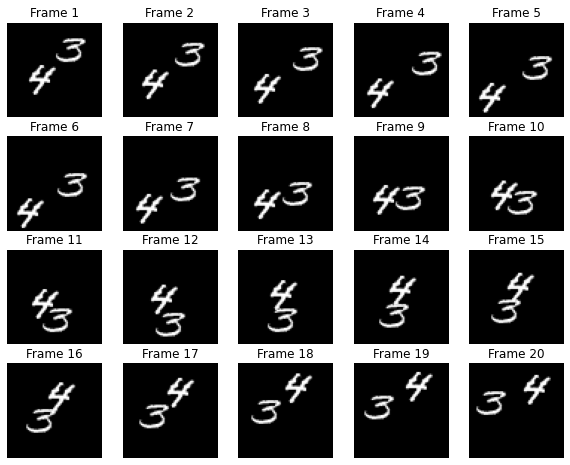

In [4]:
# Создаем холст для просмотра
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Выбираем случайный набор изображений и строим все его кадры
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Подписываем номер кадра
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [8]:
# Создаем входной слой с размерами изображения, но без количества кадров
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# Создадим 3 "ConvLSTM2D" слоя с пакетной нормализацией,
# и слой "Conv3D" для пространственно-времеменных выходов
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)
# Построим модель и скомпилируем ее
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

In [9]:
# Задаем функции вызовов для отслеживания прогресса и остановки, если модель уже перестанет обучатся
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Задаем гиперпараметры модели 
epochs = 20
batch_size = 5

# Обучаем модель на тренировачных данных
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20
180/180 [==============================] - 3255s 18s/step - loss: 0.1113 - val_loss: 0.2192 - lr: 0.0010
Epoch 2/20
180/180 [==============================] - 3343s 19s/step - loss: 0.0308 - val_loss: 0.1581 - lr: 0.0010
Epoch 3/20
180/180 [==============================] - 3293s 18s/step - loss: 0.0276 - val_loss: 0.0757 - lr: 0.0010
Epoch 4/20
180/180 [==============================] - 3385s 19s/step - loss: 0.0265 - val_loss: 0.0406 - lr: 0.0010
Epoch 5/20
180/180 [==============================] - 3403s 19s/step - loss: 0.0261 - val_loss: 0.0325 - lr: 0.0010
Epoch 6/20
180/180 [==============================] - 3386s 19s/step - loss: 0.0256 - val_loss: 0.0304 - lr: 0.0010
Epoch 7/20
180/180 [==============================] - 3466s 19s/step - loss: 0.0252 - val_loss: 0.0263 - lr: 0.0010
Epoch 8/20
180/180 [==============================] - 3398s 19s/step - loss: 0.0251 - val_loss: 0.0247 - lr: 0.0010
Epoch 9/20
180/180 [==============================] - 3381s 19s/step - l

In [61]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 64, 64, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, None, 64, 64, 64)  416256    
                                                                 
 batch_normalization_2 (Batc  (None, None, 64, 64, 64)  256      
 hNormalization)                                                 
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168    
                                                                 
 batch_normalization_3 (Batc  (None, None, 64, 64, 64)  256      
 hNormalization)                                                 
                                                           

2022-01-27 16:40:30.690391: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


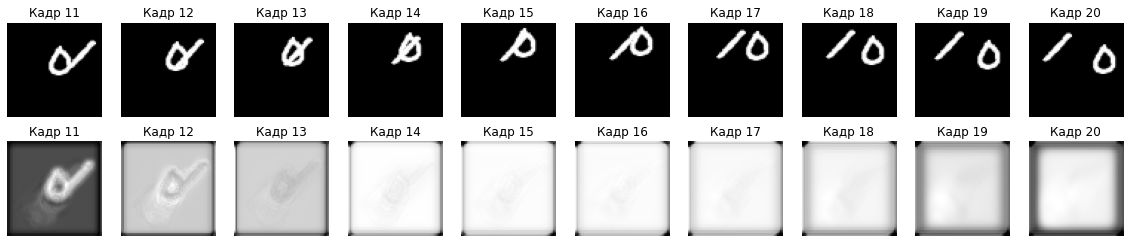

In [5]:
#model = keras.models.load_model('model')

# Выбираем случайный пример из тестовой выборки
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Делим на первые и последние 10 кадров
frames = example[:10, ...]
original_frames = example[10:, ...]

# Предсказываем 10 кадров на основе первых 10
for _ in range(10):
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    
    # Расширяем набор предсказанных кадров
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Собираем холст из оригинальных и предсказанных кадров
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Рисуем оригинальные кадры (вверху)
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Кадр {idx + 11}")
    ax.axis("off")

# Рисуем предсказанные кадры (внизу)
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Кадр {idx + 11}")
    ax.axis("off")

plt.show()

In [6]:
# Выбираем несколько случайных наборов из тестовой выборки
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Проходим по ним и предсказываем кадры для каждого набора
predicted_videos = []
for example in examples:
    # Предсказываем 10 кадров на основе первых 10
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Предсказываем 10 кадров на основе первых 10
    for i in range(10):
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
        new_predictions[i] = predicted_frame
    # Создаем и сохраняем GIF для каждого набора оригинальных и предсказанных кадров
    for frame_set in [original_frames, new_predictions]:
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Смотрим GIF
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

 Truth	Prediction
